In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor,Compose
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.utils import save_image

In [2]:
torch.cuda.is_available()

True

In [3]:
data = MNIST(root = 'data',train=True,download=True,transform=Compose([ToTensor()]))

In [4]:
img,label = data[0]

In [5]:
torch.min(img), torch.max(img)

(tensor(0.), tensor(1.))

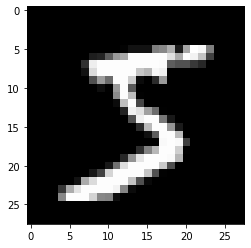

In [6]:
plt.imshow(img[0],cmap='gray')

In [7]:
batch_size = 100
data_loader = DataLoader(data,batch_size,shuffle = True)

torch.Size([100, 1, 28, 28])
tensor([6, 5, 0, 7, 5, 0, 9, 5, 1, 5, 4, 2, 4, 3, 7, 4, 7, 9, 3, 6, 4, 6, 1, 9,
        1, 5, 0, 7, 5, 2, 4, 4, 6, 8, 1, 9, 8, 2, 8, 1, 0, 6, 3, 6, 1, 7, 6, 5,
        6, 1, 9, 6, 3, 5, 4, 0, 2, 8, 6, 3, 4, 9, 1, 3, 9, 8, 3, 8, 5, 1, 4, 9,
        0, 1, 1, 1, 6, 7, 2, 7, 3, 5, 8, 9, 1, 8, 6, 7, 5, 1, 7, 8, 1, 6, 2, 3,
        0, 7, 6, 9])


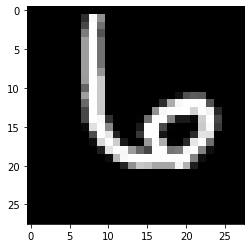

In [8]:
for img_batch,label_batch in data_loader:
    print(img_batch.shape)
    print(label_batch)
    plt.imshow(img_batch[0][0],cmap='gray')
    break

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
image_size = 784
hidden_size = 256
latent_size = 64

## Discriminator

In [11]:
discriminator = nn.Sequential(
                nn.Linear(image_size, hidden_size),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_size, hidden_size),
                nn.LeakyReLU(0.2),
                nn.Linear(hidden_size,1),
                nn.Sigmoid())

In [12]:
discriminator.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

## Generator

In [13]:
def denormalize(x):
    out = (x+1) / 2
    return out.clamp(0,1)

In [14]:
generator = nn.Sequential(
            nn.Linear(latent_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,image_size),
            nn.Tanh())

In [15]:
y = generator(torch.randn(2, latent_size))
gen_imgs = denormalize(y.reshape((-1,28,28)).detach())

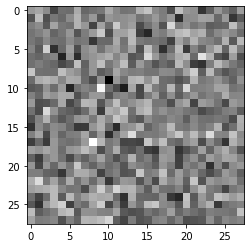

In [16]:
plt.imshow(gen_imgs[0],cmap='gray')

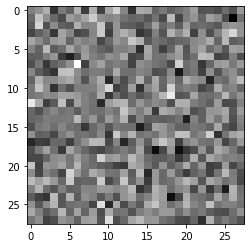

In [17]:
plt.imshow(gen_imgs[1],cmap='gray')

In [18]:
generator.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Training discriminator

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [20]:
def train_discriminator(images):
    # Labels later used as input for BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    # Loss for real images
    outputs = discriminator(images)
    d_loss_real = criterion(outputs,real_labels)
    real_score = outputs
    
    # Loss for fake images
    z = torch.randn(batch_size,latent_size).to(device)
    fake_images = generator(z)
    outputs = discriminator(fake_images)
    d_loss_fake = criterion(outputs,fake_labels)
    fake_score = outputs
    
    
    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust parameters
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [21]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002)

##  Training generator

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(discriminator(fake_images), labels)
    
    # Backprop
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [23]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.0002)

##  Training

In [24]:
import os
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [25]:
img_batch.size(0)

100

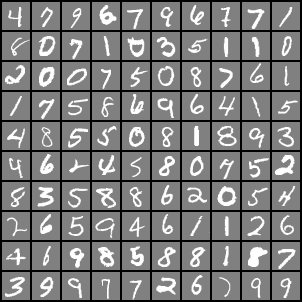

In [26]:
for images, _ in data_loader:
    images = images.reshape(images.size(0),1,28,28)
    save_image(denormalize(images),os.path.join(sample_dir,'real_images.png'), nrow=10)
    break
Image(os.path.join(sample_dir,'real_images.png'))

Saving fake_images-0000.png


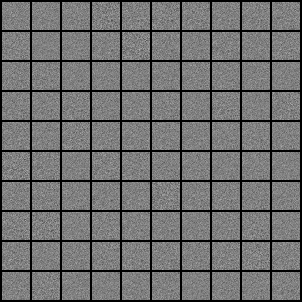

In [27]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving',fake_fname)
    save_image(denormalize(fake_images),os.path.join(sample_dir,fake_fname),nrow=10)
# Before Training
save_fake_images(0)
Image(os.path.join(sample_dir,'fake_images-0000.png'))

In [30]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses,g_losses,real_scores,fake_scores = [],[],[],[]

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # load a batch and transform to vectors
        images = images.reshape(batch_size,-1).to(device)
        
        # train
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # inspect loss
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),real_score.mean().item(), fake_score.mean().item()))
    # save image
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.1257, g_loss: 4.2984, D(x): 0.92, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.2206, g_loss: 3.6934, D(x): 0.93, D(G(z)): 0.11
Epoch [0/300], Step [600/600], d_loss: 0.6237, g_loss: 1.9018, D(x): 0.79, D(G(z)): 0.28
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3589, g_loss: 2.9982, D(x): 0.86, D(G(z)): 0.12
Epoch [1/300], Step [400/600], d_loss: 0.9134, g_loss: 2.2220, D(x): 0.73, D(G(z)): 0.35
Epoch [1/300], Step [600/600], d_loss: 1.2320, g_loss: 2.3369, D(x): 0.54, D(G(z)): 0.33
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.4218, g_loss: 2.0956, D(x): 0.81, D(G(z)): 0.17
Epoch [2/300], Step [400/600], d_loss: 0.4521, g_loss: 2.7118, D(x): 0.86, D(G(z)): 0.21
Epoch [2/300], Step [600/600], d_loss: 0.2283, g_loss: 2.7639, D(x): 0.91, D(G(z)): 0.10
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1211, g_loss: 3.6636, D(x): 0.96, D(G(z)): 0.05
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.0766, g_loss: 6.8498, D(x): 0.97, D(G(z)): 0.02
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.1697, g_loss: 6.1332, D(x): 0.98, D(G(z)): 0.10
Epoch [28/300], Step [400/600], d_loss: 0.0956, g_loss: 9.7508, D(x): 0.96, D(G(z)): 0.01
Epoch [28/300], Step [600/600], d_loss: 0.0822, g_loss: 7.8018, D(x): 0.96, D(G(z)): 0.01
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.0882, g_loss: 7.9371, D(x): 0.98, D(G(z)): 0.05
Epoch [29/300], Step [400/600], d_loss: 0.0990, g_loss: 6.4431, D(x): 0.97, D(G(z)): 0.03
Epoch [29/300], Step [600/600], d_loss: 0.0539, g_loss: 6.9543, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.1834, g_loss: 6.3121, D(x): 0.99, D(G(z)): 0.07
Epoch [30/300], Step [400/600], d_loss: 0.0665, g_loss: 5.4874, D(x): 0.99, D(G(z)): 0.04
Epoch [30/300], Step [600/600], d_loss: 0.1727, g_loss: 6.4242, D(x): 0.93, D(G(z)): 0.03
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.1156, g_loss: 5.5885, D(x): 0.98, D(G(z)): 0.06
Epoch [55/300], Step [600/600], d_loss: 0.1442, g_loss: 6.4057, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.1437, g_loss: 6.4557, D(x): 0.99, D(G(z)): 0.08
Epoch [56/300], Step [400/600], d_loss: 0.1376, g_loss: 8.4528, D(x): 0.94, D(G(z)): 0.01
Epoch [56/300], Step [600/600], d_loss: 0.2071, g_loss: 5.5607, D(x): 0.96, D(G(z)): 0.07
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.0778, g_loss: 7.7893, D(x): 0.96, D(G(z)): 0.02
Epoch [57/300], Step [400/600], d_loss: 0.1017, g_loss: 8.3036, D(x): 0.95, D(G(z)): 0.02
Epoch [57/300], Step [600/600], d_loss: 0.0913, g_loss: 6.1102, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.1243, g_loss: 5.9269, D(x): 0.98, D(G(z)): 0.05
Epoch [58/300], Step [400/600], d_loss: 0.0577, g_loss: 6.8395, D(x): 0.98, D(G(z)): 0.03
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.1803, g_loss: 5.7663, D(x): 0.94, D(G(z)): 0.05
Epoch [83/300], Step [400/600], d_loss: 0.1507, g_loss: 5.3520, D(x): 0.97, D(G(z)): 0.07
Epoch [83/300], Step [600/600], d_loss: 0.1948, g_loss: 6.4506, D(x): 0.95, D(G(z)): 0.07
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.1342, g_loss: 5.2358, D(x): 0.96, D(G(z)): 0.07
Epoch [84/300], Step [400/600], d_loss: 0.1033, g_loss: 5.8564, D(x): 0.97, D(G(z)): 0.05
Epoch [84/300], Step [600/600], d_loss: 0.2047, g_loss: 5.6356, D(x): 0.95, D(G(z)): 0.08
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.1943, g_loss: 5.6526, D(x): 0.94, D(G(z)): 0.07
Epoch [85/300], Step [400/600], d_loss: 0.1499, g_loss: 6.4473, D(x): 0.93, D(G(z)): 0.02
Epoch [85/300], Step [600/600], d_loss: 0.1137, g_loss: 4.5642, D(x): 0.95, D(G(z)): 0.04
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.1806, g_loss: 5.5202, D(x): 0.93, D(G(z)): 0.03
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.3168, g_loss: 3.8164, D(x): 0.94, D(G(z)): 0.14
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.3917, g_loss: 4.8602, D(x): 0.94, D(G(z)): 0.15
Epoch [111/300], Step [400/600], d_loss: 0.2325, g_loss: 4.2420, D(x): 0.96, D(G(z)): 0.12
Epoch [111/300], Step [600/600], d_loss: 0.1997, g_loss: 4.6015, D(x): 0.93, D(G(z)): 0.07
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.2605, g_loss: 3.9059, D(x): 0.90, D(G(z)): 0.07
Epoch [112/300], Step [400/600], d_loss: 0.3352, g_loss: 4.3324, D(x): 0.86, D(G(z)): 0.05
Epoch [112/300], Step [600/600], d_loss: 0.2529, g_loss: 5.1970, D(x): 0.90, D(G(z)): 0.06
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.1946, g_loss: 4.4157, D(x): 0.93, D(G(z)): 0.08
Epoch [113/300], Step [400/600], d_loss: 0.3159, g_loss: 4.7769, D(x): 0.89, D(G(z)): 0.08
Epoch [113/300], Step [600/600], d_loss: 0.2600, g_loss: 4.3312, D(x): 0.91, D(G(z)): 0.07
Saving

Epoch [138/300], Step [200/600], d_loss: 0.1818, g_loss: 5.0594, D(x): 0.92, D(G(z)): 0.06
Epoch [138/300], Step [400/600], d_loss: 0.1775, g_loss: 4.5563, D(x): 0.94, D(G(z)): 0.07
Epoch [138/300], Step [600/600], d_loss: 0.3475, g_loss: 4.6375, D(x): 0.90, D(G(z)): 0.10
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.3638, g_loss: 4.3116, D(x): 0.88, D(G(z)): 0.10
Epoch [139/300], Step [400/600], d_loss: 0.2947, g_loss: 4.2478, D(x): 0.92, D(G(z)): 0.10
Epoch [139/300], Step [600/600], d_loss: 0.4321, g_loss: 3.7749, D(x): 0.90, D(G(z)): 0.11
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.3881, g_loss: 5.2299, D(x): 0.86, D(G(z)): 0.07
Epoch [140/300], Step [400/600], d_loss: 0.2504, g_loss: 4.1601, D(x): 0.91, D(G(z)): 0.08
Epoch [140/300], Step [600/600], d_loss: 0.4147, g_loss: 3.9370, D(x): 0.87, D(G(z)): 0.12
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.2430, g_loss: 4.1909, D(x): 0.94, D(G(z)): 0.08
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.4454, g_loss: 4.3354, D(x): 0.84, D(G(z)): 0.09
Epoch [165/300], Step [600/600], d_loss: 0.5258, g_loss: 3.9480, D(x): 0.88, D(G(z)): 0.18
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.3151, g_loss: 3.8745, D(x): 0.90, D(G(z)): 0.09
Epoch [166/300], Step [400/600], d_loss: 0.3268, g_loss: 4.0537, D(x): 0.95, D(G(z)): 0.14
Epoch [166/300], Step [600/600], d_loss: 0.3844, g_loss: 4.1635, D(x): 0.91, D(G(z)): 0.13
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.4287, g_loss: 3.7865, D(x): 0.82, D(G(z)): 0.07
Epoch [167/300], Step [400/600], d_loss: 0.6967, g_loss: 3.1399, D(x): 0.92, D(G(z)): 0.24
Epoch [167/300], Step [600/600], d_loss: 0.2016, g_loss: 4.1588, D(x): 0.92, D(G(z)): 0.07
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.4758, g_loss: 3.8208, D(x): 0.86, D(G(z)): 0.12
Epoch [168/300], Step [400/600], d_loss: 0.4345, g_loss: 3.3494, D(x): 0.84, D(G(z)): 0.08
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.5241, g_loss: 4.3026, D(x): 0.80, D(G(z)): 0.10
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.4224, g_loss: 3.7598, D(x): 0.90, D(G(z)): 0.18
Epoch [193/300], Step [400/600], d_loss: 0.3234, g_loss: 3.6092, D(x): 0.91, D(G(z)): 0.14
Epoch [193/300], Step [600/600], d_loss: 0.4586, g_loss: 3.6550, D(x): 0.88, D(G(z)): 0.13
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.4406, g_loss: 4.3152, D(x): 0.85, D(G(z)): 0.11
Epoch [194/300], Step [400/600], d_loss: 0.2915, g_loss: 4.3550, D(x): 0.92, D(G(z)): 0.11
Epoch [194/300], Step [600/600], d_loss: 0.5128, g_loss: 4.0371, D(x): 0.84, D(G(z)): 0.11
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.6655, g_loss: 3.4065, D(x): 0.79, D(G(z)): 0.15
Epoch [195/300], Step [400/600], d_loss: 0.6424, g_loss: 3.5833, D(x): 0.82, D(G(z)): 0.18
Epoch [195/300], Step [600/600], d_loss: 0.4162, g_loss: 3.3619, D(x): 0.93, D(G(z)): 0.18
Saving

Epoch [220/300], Step [200/600], d_loss: 0.5174, g_loss: 2.6998, D(x): 0.83, D(G(z)): 0.14
Epoch [220/300], Step [400/600], d_loss: 0.3084, g_loss: 4.1199, D(x): 0.92, D(G(z)): 0.11
Epoch [220/300], Step [600/600], d_loss: 0.4636, g_loss: 3.9809, D(x): 0.86, D(G(z)): 0.15
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.5048, g_loss: 4.3989, D(x): 0.86, D(G(z)): 0.13
Epoch [221/300], Step [400/600], d_loss: 0.3956, g_loss: 3.6998, D(x): 0.86, D(G(z)): 0.13
Epoch [221/300], Step [600/600], d_loss: 0.5123, g_loss: 4.0546, D(x): 0.87, D(G(z)): 0.16
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.4963, g_loss: 4.3202, D(x): 0.81, D(G(z)): 0.11
Epoch [222/300], Step [400/600], d_loss: 0.4066, g_loss: 3.6938, D(x): 0.87, D(G(z)): 0.14
Epoch [222/300], Step [600/600], d_loss: 0.2786, g_loss: 4.3654, D(x): 0.91, D(G(z)): 0.09
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.4432, g_loss: 4.0964, D(x): 0.84, D(G(z)): 0.12
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.3437, g_loss: 3.4295, D(x): 0.91, D(G(z)): 0.12
Epoch [247/300], Step [600/600], d_loss: 0.4001, g_loss: 3.7141, D(x): 0.82, D(G(z)): 0.10
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.3521, g_loss: 4.1190, D(x): 0.88, D(G(z)): 0.11
Epoch [248/300], Step [400/600], d_loss: 0.4580, g_loss: 3.4934, D(x): 0.83, D(G(z)): 0.10
Epoch [248/300], Step [600/600], d_loss: 0.4189, g_loss: 4.0684, D(x): 0.87, D(G(z)): 0.13
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.4847, g_loss: 2.9614, D(x): 0.91, D(G(z)): 0.19
Epoch [249/300], Step [400/600], d_loss: 0.2731, g_loss: 3.6021, D(x): 0.91, D(G(z)): 0.10
Epoch [249/300], Step [600/600], d_loss: 0.3966, g_loss: 3.5778, D(x): 0.89, D(G(z)): 0.13
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.5212, g_loss: 3.7719, D(x): 0.87, D(G(z)): 0.15
Epoch [250/300], Step [400/600], d_loss: 0.4059, g_loss: 4.2157, D(x): 0.83, D(G(z)): 0.06
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.4894, g_loss: 2.9763, D(x): 0.94, D(G(z)): 0.24
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.4512, g_loss: 3.2692, D(x): 0.86, D(G(z)): 0.14
Epoch [275/300], Step [400/600], d_loss: 0.5277, g_loss: 3.3305, D(x): 0.84, D(G(z)): 0.15
Epoch [275/300], Step [600/600], d_loss: 0.4896, g_loss: 3.8457, D(x): 0.81, D(G(z)): 0.08
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.5843, g_loss: 3.2243, D(x): 0.89, D(G(z)): 0.23
Epoch [276/300], Step [400/600], d_loss: 0.3707, g_loss: 3.3703, D(x): 0.87, D(G(z)): 0.12
Epoch [276/300], Step [600/600], d_loss: 0.3747, g_loss: 3.1727, D(x): 0.89, D(G(z)): 0.14
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.4792, g_loss: 3.4294, D(x): 0.88, D(G(z)): 0.17
Epoch [277/300], Step [400/600], d_loss: 0.3340, g_loss: 2.8226, D(x): 0.89, D(G(z)): 0.12
Epoch [277/300], Step [600/600], d_loss: 0.5396, g_loss: 3.8865, D(x): 0.85, D(G(z)): 0.15
Saving

In [31]:
torch.save(generator.state_dict(),'generator.ckpt')
torch.save(discriminator.state_dict(),'discriminator.ckpt')

In [32]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/home/pradyumna/Desktop/project/gans/gans_training.avi

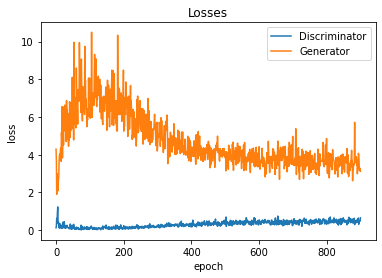

In [33]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

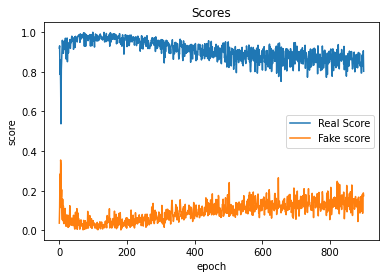

In [34]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');